# Car Detection

In [358]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [317]:
def load_ts_file(file_path):
    X, y = [], []
    started = False

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()

            if line.lower().startswith("@data"):
                started = True
                continue

            if not started or line.startswith("@") or line.startswith("#") or not line:
                continue

            series_part, label_part = line.split(':')
            values = [float(x) for x in series_part.split(',')]
            label = int(label_part)

            X.append(values)
            y.append(label)

    return np.array(X), np.array(y)


print("📥 Loading data...")

X_train_raw, y_train_raw = load_ts_file('data/Car/Car_TRAIN.ts')
X_test_raw, y_test_raw = load_ts_file('data/Car/Car_TEST.ts')

# Gabungkan semua data
X_all = np.vstack((X_train_raw, X_test_raw))
y_all = np.hstack((y_train_raw, y_test_raw))

print("Total data:", X_all.shape)

📥 Loading data...
Total data: (120, 577)


In [318]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all   # menjaga proporsi kelas
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (96, 577)
Test shape : (24, 577)


In [ ]:
print("\n📊 Data Understanding")
print("Jumlah kelas:", np.unique(y_train))
print("Jumlah data train:", len(y_train))
print("Jumlah data test :", len(y_test))
print("Panjang time series:", X_train.shape[1])



📊 Data Understanding
Jumlah kelas: [1 2 3 4]
Jumlah data train: 96
Jumlah data test : 24
Panjang time series: 577


In [361]:
df = pd.DataFrame(X_train)
print("Statistik data train:")
print(df.describe())

Statistik data train:
             0          1          2          3          4          5    \
count  96.000000  96.000000  96.000000  96.000000  96.000000  96.000000   
mean    1.632087   1.595342   1.562173   1.533606   1.506904   1.482206   
std     0.146198   0.146003   0.144331   0.143997   0.141947   0.138751   
min     1.299280   1.261463   1.228439   1.226740   1.225394   1.211650   
25%     1.536229   1.501988   1.466873   1.434125   1.420212   1.407773   
50%     1.631578   1.594862   1.561195   1.533345   1.502565   1.472113   
75%     1.713104   1.675100   1.644154   1.613675   1.583454   1.565564   
max     2.141710   2.103058   2.064416   2.025784   1.987163   1.948553   

             6          7          8          9    ...        567        568  \
count  96.000000  96.000000  96.000000  96.000000  ...  96.000000  96.000000   
mean    1.458902   1.439490   1.423070   1.404802  ...   1.459594   1.474470   
std     0.138865   0.140852   0.141713   0.144899  ...   0.151

In [362]:
labels, counts = np.unique(y_train, return_counts=True)
df_dist = pd.DataFrame({
    "Label": labels,
    "Jumlah Data": counts
})

print(df_dist)


   Label  Jumlah Data
0      1           24
1      2           24
2      3           24
3      4           24


In [320]:
def z_normalize(X):
    mean = X.mean(axis=1, keepdims=True)
    std = X.std(axis=1, keepdims=True)
    return (X - mean) / (std + 1e-8)

X_train_norm = z_normalize(X_train)
X_test_norm = z_normalize(X_test)


In [321]:
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

print("Dimensi setelah PCA:", X_train_pca.shape[1])


Dimensi setelah PCA: 8


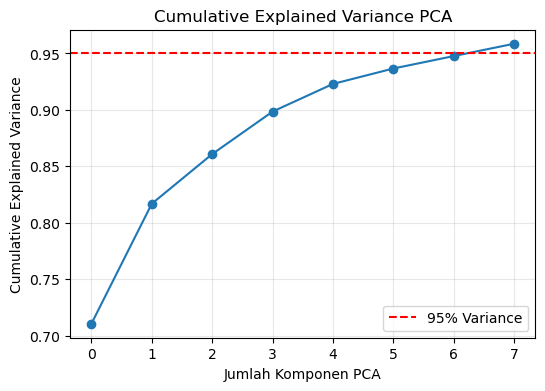

In [322]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Jumlah Komponen PCA')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance PCA')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


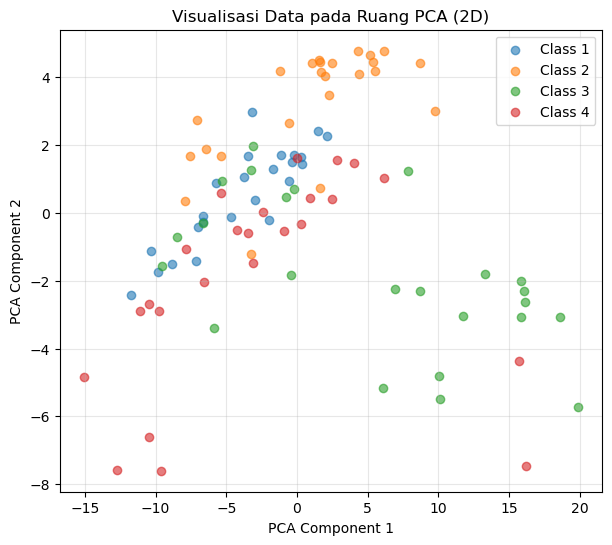

In [323]:
plt.figure(figsize=(7, 6))

for cls in np.unique(y_train):
    idx = np.where(y_train == cls)
    plt.scatter(
        X_train_pca[idx, 0],
        X_train_pca[idx, 1],
        label=f'Class {cls}',
        alpha=0.6
    )

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Visualisasi Data pada Ruang PCA (2D)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


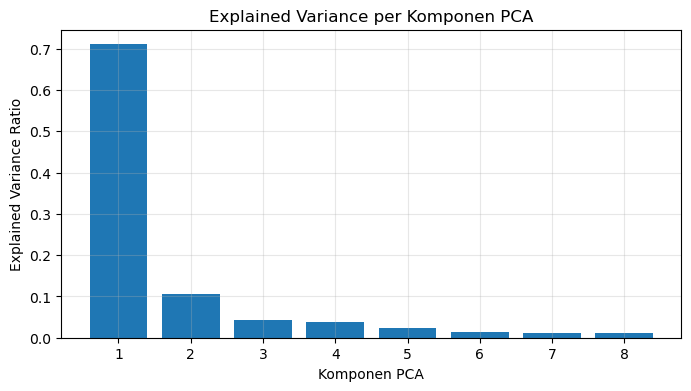

In [324]:
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1),
        pca.explained_variance_ratio_)
plt.xlabel('Komponen PCA')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance per Komponen PCA')
plt.grid(alpha=0.3)
plt.show()


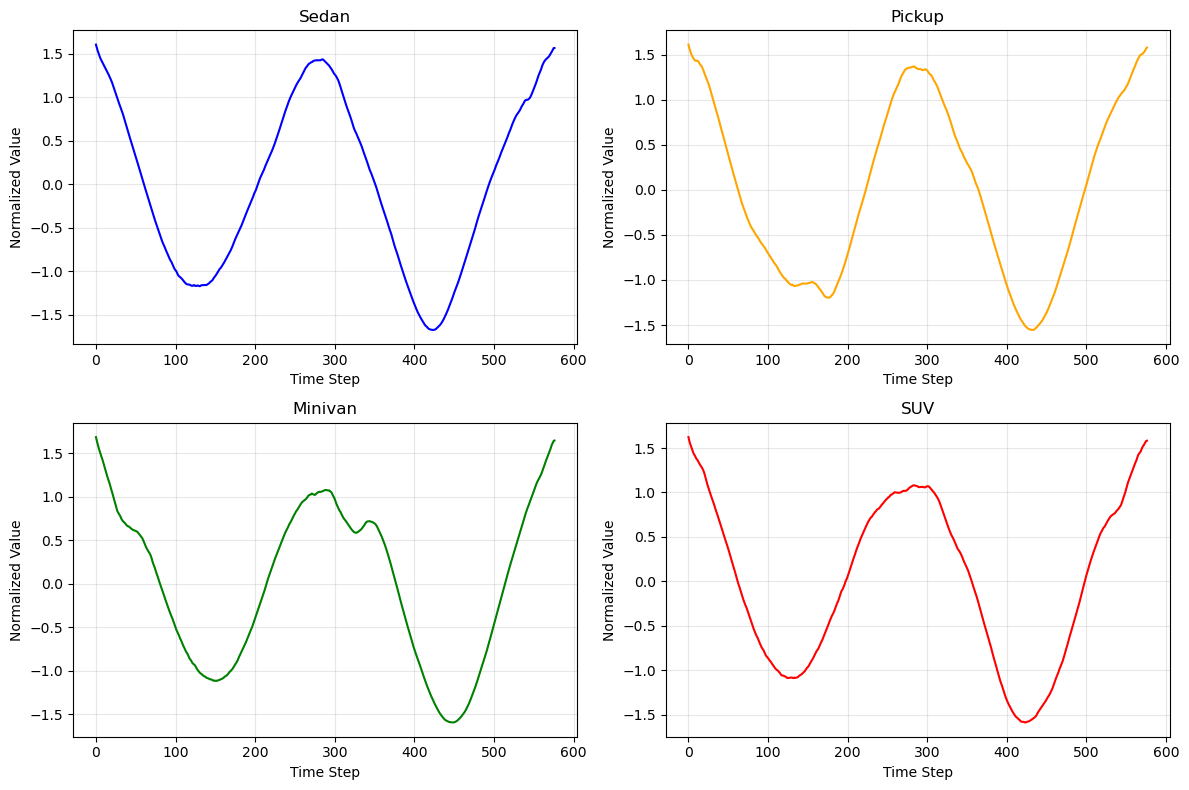

In [325]:
label_map = {1: 'Sedan', 2: 'Pickup', 3: 'Minivan', 4: 'SUV'}
colors = ['blue', 'orange', 'green', 'red']

plt.figure(figsize=(12, 8))

for i, cls in enumerate(sorted(np.unique(y_train))):
    idx = np.where(y_train == cls)[0]
    mean_series = X_train_norm[idx].mean(axis=0)

    plt.subplot(2, 2, i+1)
    plt.plot(mean_series, color=colors[i])
    plt.title(label_map[cls])
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Value")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [326]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_norm, y_train)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [330]:
svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
)

svm_model.fit(X_train_norm, y_train)


SVC(C=10)

In [331]:
y_pred_rf = rf_model.predict(X_test_norm)

print("=== RANDOM FOREST ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


=== RANDOM FOREST ===
Accuracy: 0.7083333333333334
              precision    recall  f1-score   support

           1       0.62      0.83      0.71         6
           2       1.00      0.67      0.80         6
           3       0.71      0.83      0.77         6
           4       0.60      0.50      0.55         6

    accuracy                           0.71        24
   macro avg       0.73      0.71      0.71        24
weighted avg       0.73      0.71      0.71        24



In [332]:
y_pred_svm = svm_model.predict(X_test_norm)

print("=== SVM ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


=== SVM ===
Accuracy: 0.7083333333333334
              precision    recall  f1-score   support

           1       0.56      0.83      0.67         6
           2       1.00      0.83      0.91         6
           3       1.00      0.67      0.80         6
           4       0.50      0.50      0.50         6

    accuracy                           0.71        24
   macro avg       0.76      0.71      0.72        24
weighted avg       0.76      0.71      0.72        24



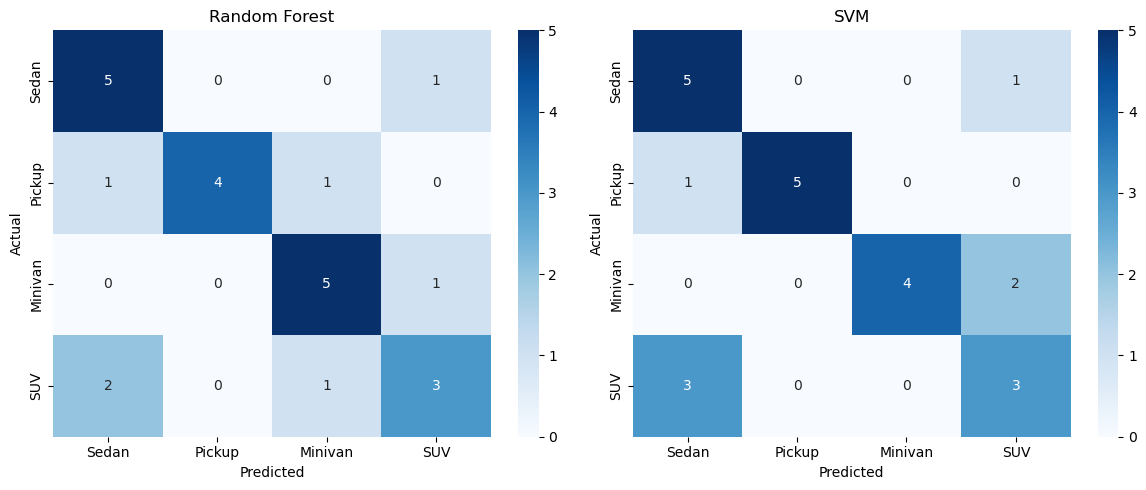

In [333]:
models = {
    "Random Forest": y_pred_rf,
    "SVM": y_pred_svm
}

plt.figure(figsize=(12, 5))

for i, (name, y_pred) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4])

    plt.subplot(1, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_map.values(),
                yticklabels=label_map.values())
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


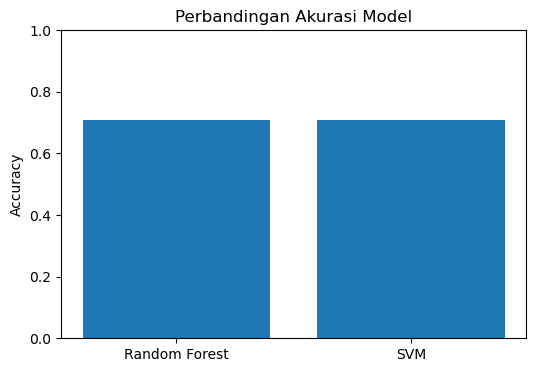

In [334]:
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_svm = accuracy_score(y_test, y_pred_svm)

plt.figure(figsize=(6, 4))
plt.bar(['Random Forest', 'SVM'], [acc_rf, acc_svm])
plt.ylabel("Accuracy")
plt.title("Perbandingan Akurasi Model")
plt.ylim(0, 1)
plt.show()


### Fine-Tuning

In [335]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_param = {
    'n_estimators': [300, 500],
    'max_depth': [15, 25, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

rf_grid = GridSearchCV(
    rf, rf_param,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_grid.fit(X_train_norm, y_train)

best_rf = rf_grid.best_estimator_

print("🔍 Tuning Random Forest...")
rf_grid.fit(X_train_norm, y_train)

print("Best RF Params:", rf_grid.best_params_)
print("Best RF CV Accuracy:", rf_grid.best_score_)


🔍 Tuning Random Forest...
Best RF Params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}
Best RF CV Accuracy: 0.6884210526315788


In [336]:
best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_test_norm)

print("=== RANDOM FOREST (TUNED) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


=== RANDOM FOREST (TUNED) ===
Accuracy: 0.7083333333333334
              precision    recall  f1-score   support

           1       0.62      0.83      0.71         6
           2       1.00      0.67      0.80         6
           3       0.71      0.83      0.77         6
           4       0.60      0.50      0.55         6

    accuracy                           0.71        24
   macro avg       0.73      0.71      0.71        24
weighted avg       0.73      0.71      0.71        24



In [337]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm_param = {
    'C': [1, 10, 50, 100],
    'gamma': ['scale', 0.01, 0.05, 0.1],
}

svm_grid = GridSearchCV(
    svm, svm_param,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

svm_grid.fit(X_train_norm, y_train)

best_svm = svm_grid.best_estimator_


print("🔍 Tuning SVM...")
svm_grid.fit(X_train_norm, y_train)

print("Best SVM Params:", svm_grid.best_params_)
print("Best SVM CV Accuracy:", svm_grid.best_score_)


🔍 Tuning SVM...
Best SVM Params: {'C': 50, 'gamma': 0.01}
Best SVM CV Accuracy: 0.8015789473684212


In [338]:
best_svm = svm_grid.best_estimator_

y_pred_svm = best_svm.predict(X_test_norm)

print("=== SVM (TUNED) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


=== SVM (TUNED) ===
Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         6
           3       0.80      0.67      0.73         6
           4       0.62      0.83      0.71         6

    accuracy                           0.83        24
   macro avg       0.86      0.83      0.84        24
weighted avg       0.86      0.83      0.84        24



In [339]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn_param = {
    'n_neighbors': [1, 3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

knn_grid = GridSearchCV(
    knn, knn_param,
    cv=5,
    scoring='accuracy'
)

knn_grid.fit(X_train_norm, y_train)

best_knn = knn_grid.best_estimator_


print("🔍 Tuning KNN...")
knn_grid.fit(X_train_norm, y_train)

print("Best KNN Params:", knn_grid.best_params_)
print("Best KNN CV Accuracy:", knn_grid.best_score_)

🔍 Tuning KNN...
Best KNN Params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best KNN CV Accuracy: 0.781578947368421


In [340]:
best_knn = knn_grid.best_estimator_

y_pred_knn = best_knn.predict(X_test_norm)
print("=== KNN (TUNED) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

=== KNN (TUNED) ===
Accuracy: 0.7916666666666666
              precision    recall  f1-score   support

           1       0.75      1.00      0.86         6
           2       1.00      0.83      0.91         6
           3       0.67      1.00      0.80         6
           4       1.00      0.33      0.50         6

    accuracy                           0.79        24
   macro avg       0.85      0.79      0.77        24
weighted avg       0.85      0.79      0.77        24



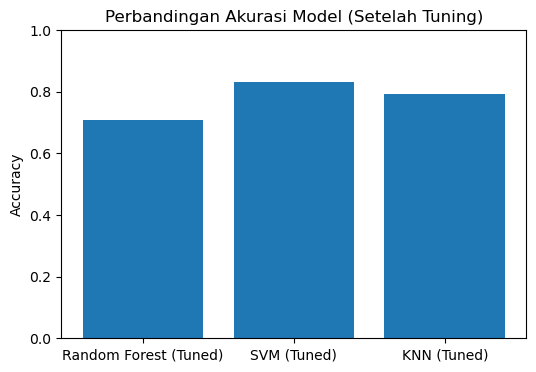

In [341]:
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_knn = accuracy_score(y_test, y_pred_knn)

plt.figure(figsize=(6, 4))
plt.bar(['Random Forest (Tuned)', 'SVM (Tuned)', 'KNN (Tuned)'], [acc_rf, acc_svm, acc_knn])
plt.ylabel("Accuracy")
plt.title("Perbandingan Akurasi Model (Setelah Tuning)")
plt.ylim(0, 1)
plt.show()


### Test Model

In [342]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample


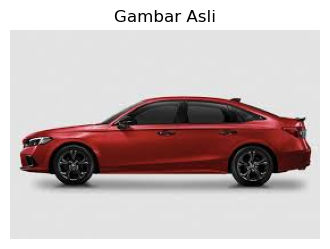

In [363]:
img = cv2.imread("images/cars/sedan-1.jpeg")  # ganti path
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4,4))
plt.imshow(img_rgb)
plt.title("Gambar Asli")
plt.axis("off")
plt.show()


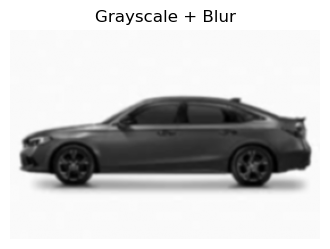

In [364]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

plt.figure(figsize=(4,4))
plt.imshow(blur, cmap="gray")
plt.title("Grayscale + Blur")
plt.axis("off")
plt.show()


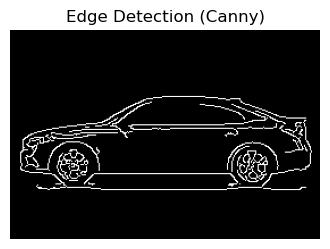

In [365]:
edges = cv2.Canny(blur, 50, 150)

plt.figure(figsize=(4,4))
plt.imshow(edges, cmap="gray")
plt.title("Edge Detection (Canny)")
plt.axis("off")
plt.show()


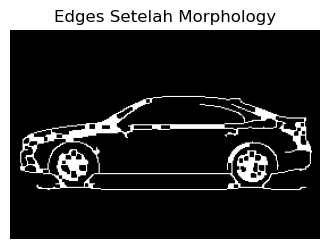

In [366]:
kernel = np.ones((3, 3), np.uint8)
edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(4,4))
plt.imshow(edges_closed, cmap="gray")
plt.title("Edges Setelah Morphology")
plt.axis("off")
plt.show()


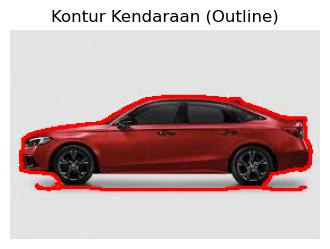

In [367]:
contours, _ = cv2.findContours(
    edges_closed,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_NONE
)

cnt = max(contours, key=cv2.contourArea)

img_contour = img_rgb.copy()
cv2.drawContours(img_contour, [cnt], -1, (255, 0, 0), 2)

plt.figure(figsize=(4,4))
plt.imshow(img_contour)
plt.title("Kontur Kendaraan (Outline)")
plt.axis("off")
plt.show()


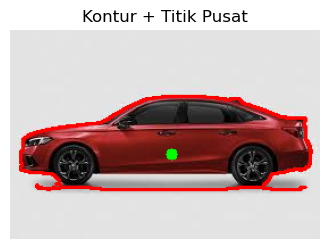

In [368]:
center = cnt.mean(axis=0)

cx, cy = int(center[0][0]), int(center[0][1])
img_center = img_contour.copy()
cv2.circle(img_center, (cx, cy), 5, (0, 255, 0), -1)

plt.figure(figsize=(4,4))
plt.imshow(img_center)
plt.title("Kontur + Titik Pusat")
plt.axis("off")
plt.show()


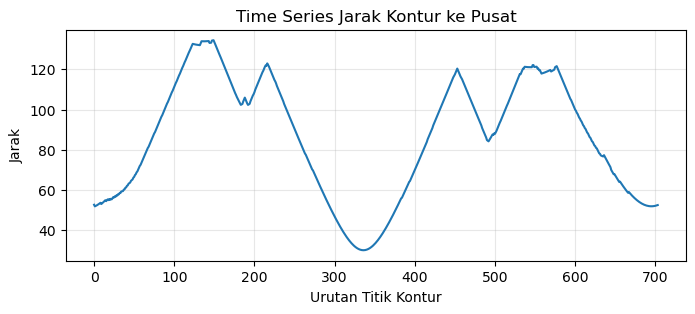

In [373]:
ts = np.linalg.norm(cnt - center, axis=2).flatten()

plt.figure(figsize=(8,3))
plt.plot(ts)
plt.title("Time Series Jarak Kontur ke Pusat")
plt.xlabel("Urutan Titik Kontur")
plt.ylabel("Jarak")
plt.grid(alpha=0.3)
plt.show()


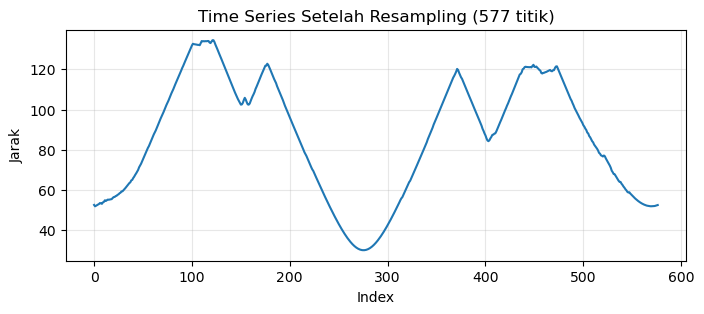

In [370]:
ts_resampled = resample(ts, 577)

plt.figure(figsize=(8,3))
plt.plot(ts_resampled)
plt.title("Time Series Setelah Resampling (577 titik)")
plt.xlabel("Index")
plt.ylabel("Jarak")
plt.grid(alpha=0.3)
plt.show()


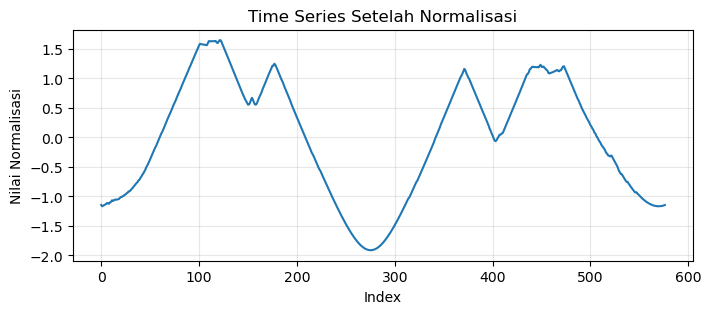

In [371]:
ts_norm = (ts_resampled - ts_resampled.mean()) / ts_resampled.std()

plt.figure(figsize=(8,3))
plt.plot(ts_norm)
plt.title("Time Series Setelah Normalisasi")
plt.xlabel("Index")
plt.ylabel("Nilai Normalisasi")
plt.grid(alpha=0.3)
plt.show()


In [372]:
label_map = {
    1: "Sedan",
    2: "Pickup",
    3: "Minivan",
    4: "SUV"
}

ts_norm = ts_norm.reshape(1, -1)

pred_label = svm_grid.predict(ts_norm)[0]
pred_name = label_map[pred_label]

print("Predicted label:", pred_label)
print("Predicted vehicle type:", pred_name)


Predicted label: 3
Predicted vehicle type: Minivan


### Test 2

In [155]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


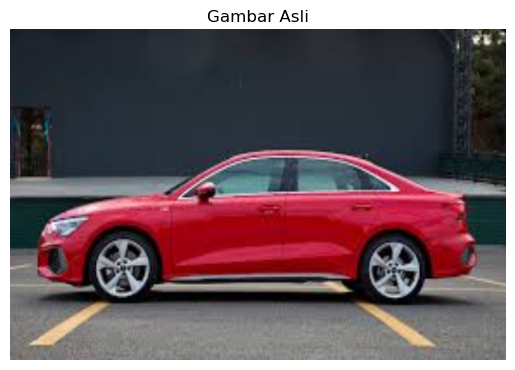

In [197]:
img = cv2.imread("images/cars/sedan.jpeg")  # GANTI PATH GAMBAR
img = cv2.resize(img, (600, 400))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Gambar Asli")
plt.axis("off")
plt.show()


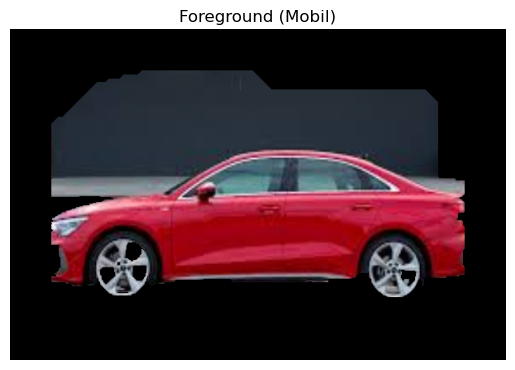

In [198]:
mask = np.zeros(img.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# ROI kasar (asumsi mobil di tengah)
rect = (50, 50, img.shape[1]-100, img.shape[0]-100)

cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
img_fg = img * mask2[:, :, np.newaxis]

plt.imshow(cv2.cvtColor(img_fg, cv2.COLOR_BGR2RGB))
plt.title("Foreground (Mobil)")
plt.axis("off")
plt.show()


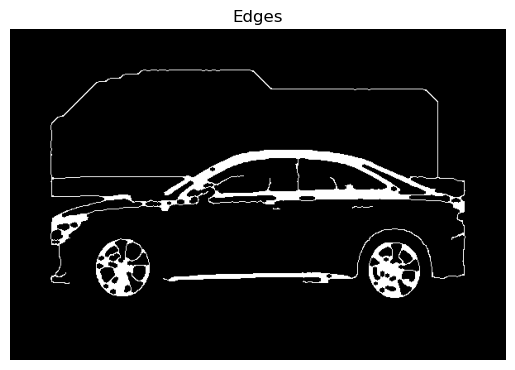

In [199]:
gray = cv2.cvtColor(img_fg, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

edges = cv2.Canny(blur, 50, 150)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

plt.imshow(edges_closed, cmap='gray')
plt.title("Edges")
plt.axis("off")
plt.show()


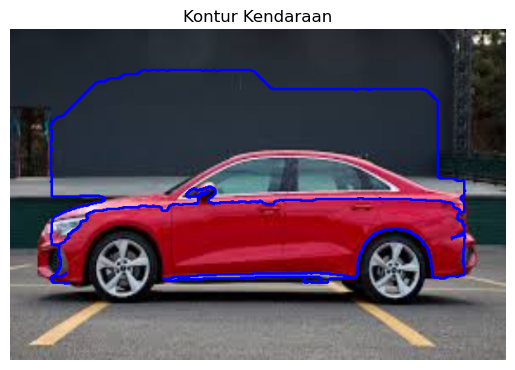

In [200]:
contours, _ = cv2.findContours(
    edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
)

# Filter area kecil
min_area = img.shape[0] * img.shape[1] * 0.05
large_contours = [c for c in contours if cv2.contourArea(c) > min_area]

cnt = max(large_contours, key=cv2.contourArea)

contour_img = img.copy()
cv2.drawContours(contour_img, [cnt], -1, (255,0,0), 2)

plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title("Kontur Kendaraan")
plt.axis("off")
plt.show()


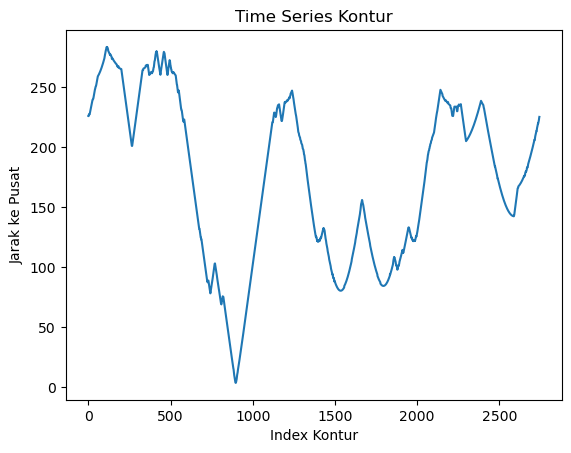

In [201]:
# Ambil titik kontur
pts = cnt.squeeze()

# Titik pusat
cx, cy = pts.mean(axis=0)

# Jarak ke pusat (shape signature)
distances = np.sqrt((pts[:,0]-cx)**2 + (pts[:,1]-cy)**2)

plt.plot(distances)
plt.title("Time Series Kontur")
plt.xlabel("Index Kontur")
plt.ylabel("Jarak ke Pusat")
plt.show()


In [202]:
TARGET_LEN = 577  # samakan dengan data training

ts_resampled = np.interp(
    np.linspace(0, len(distances)-1, TARGET_LEN),
    np.arange(len(distances)),
    distances
)

ts_norm = (ts_resampled - ts_resampled.mean()) / ts_resampled.std()


In [203]:
# Mapping kelas (SESUIKAN DENGAN DATASET)
class_names = {
    0: "Sedan",
    1: "Pickup",
    2: "Minivan",
    3: "SUV"
}

ts_norm = ts_norm.reshape(1, -1)
pred = svm_grid.predict(ts_norm)[0]

print("Predicted class ID:", pred)
print("Predicted class name:", class_names.get(pred, "Unknown"))


Predicted class ID: 2
Predicted class name: Minivan


### Simpan Model

In [374]:
import joblib

joblib.dump(svm_grid.best_estimator_, "models/svm_car_model.pkl")
joblib.dump(pca, "models/pca.pkl")


['models/pca.pkl']